# Filtered Noise

visualizations of the filtered noise ddsp component

In [47]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import IPython

sns.set_theme()

In [34]:
def plot(ax, x):
    ax.plot(range(len(x)), x)

In [69]:
# dummy data - this would be the decoder outputs that determine the noise filtering magnitudes
# shape - (batch_size, n_frames, n_filter_banks)

magnitudes = torch.randint(0, 20, (5, 2000, 8), dtype=torch.float32)
magnitudes = 2 * torch.sigmoid(magnitudes - 5)**2.3 + 1e-7
magnitudes

tensor([[[1.9693e+00, 1.5014e-02, 2.0000e+00,  ..., 1.8026e-03,
          4.0613e-01, 1.9182e+00],
         [2.0000e+00, 1.9886e+00, 1.9693e+00,  ..., 1.7885e+00,
          1.9999e+00, 2.0000e+00],
         [1.9182e+00, 1.7885e+00, 1.9392e-04,  ..., 2.0000e+00,
          1.7885e+00, 2.0000e+00],
         ...,
         [1.8026e-03, 9.7554e-02, 1.9998e+00,  ..., 1.9886e+00,
          1.7885e+00, 2.0000e+00],
         [1.9999e+00, 1.9182e+00, 2.0000e+00,  ..., 9.7302e-01,
          9.7302e-01, 2.0000e+00],
         [1.9182e+00, 1.8026e-03, 1.5014e-02,  ..., 1.5014e-02,
          2.0050e-05, 4.0613e-01]],

        [[1.9994e+00, 1.4936e+00, 4.0613e-01,  ..., 2.0000e+00,
          1.9693e+00, 9.7302e-01],
         [9.7554e-02, 1.4936e+00, 2.0000e+00,  ..., 9.7302e-01,
          1.9886e+00, 1.7885e+00],
         [1.9392e-04, 2.0000e+00, 1.9999e+00,  ..., 2.0000e+00,
          1.9985e+00, 4.0613e-01],
         ...,
         [1.7885e+00, 1.9182e+00, 1.9985e+00,  ..., 2.0000e+00,
          1.493

In [70]:
# the target length of a single filtering in terms of samples
target_size = 8

In [71]:
zero_phase = torch.view_as_complex(torch.stack([magnitudes, torch.zeros_like(magnitudes)], -1))
irs = torch.fft.irfft(zero_phase)
irs.shape

torch.Size([5, 2000, 14])

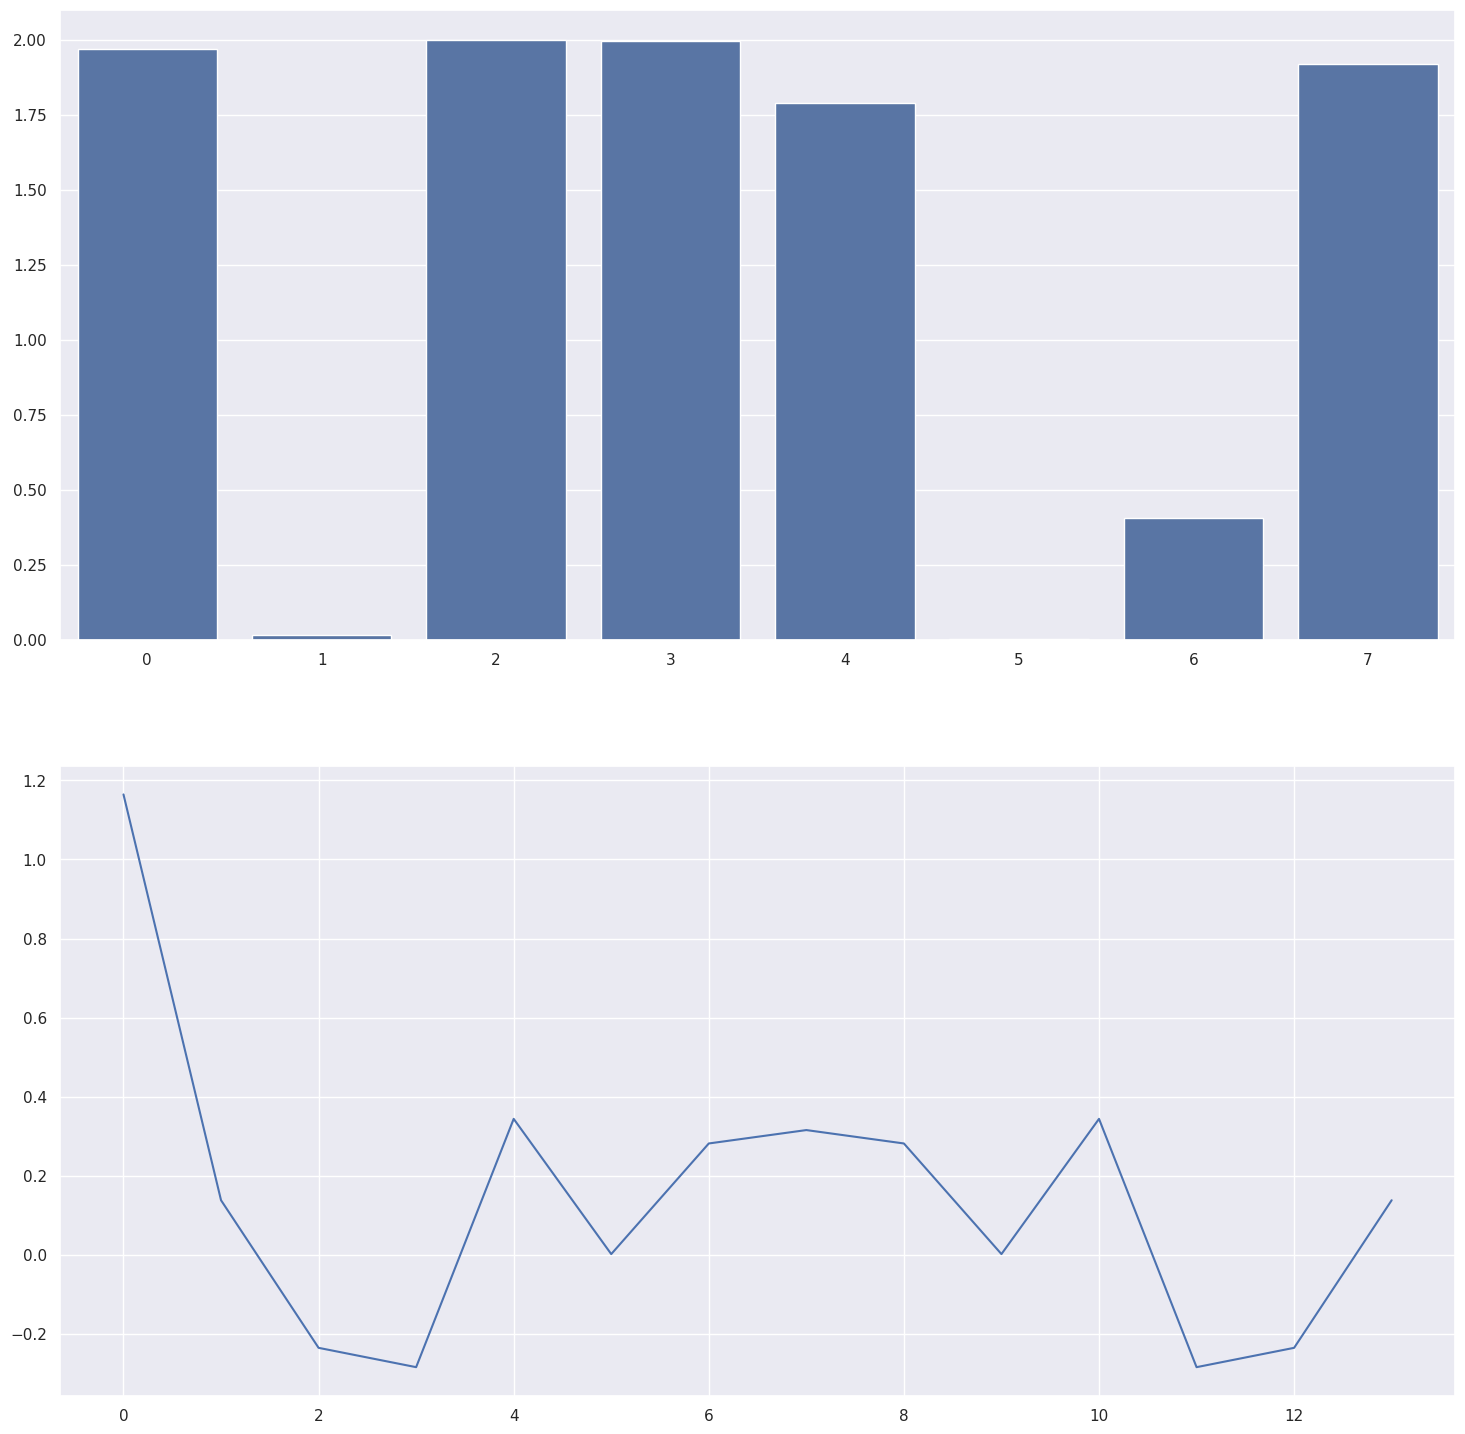

In [72]:
fr = magnitudes[0, 0, ...]
ir = irs[0, 0, ...]
fig, axs = plt.subplots(2, 1, figsize=(18, 18))
sns.barplot(pd.Series(fr), ax=axs[0])
plot(axs[1], ir)

14
torch.Size([5, 2000, 8])


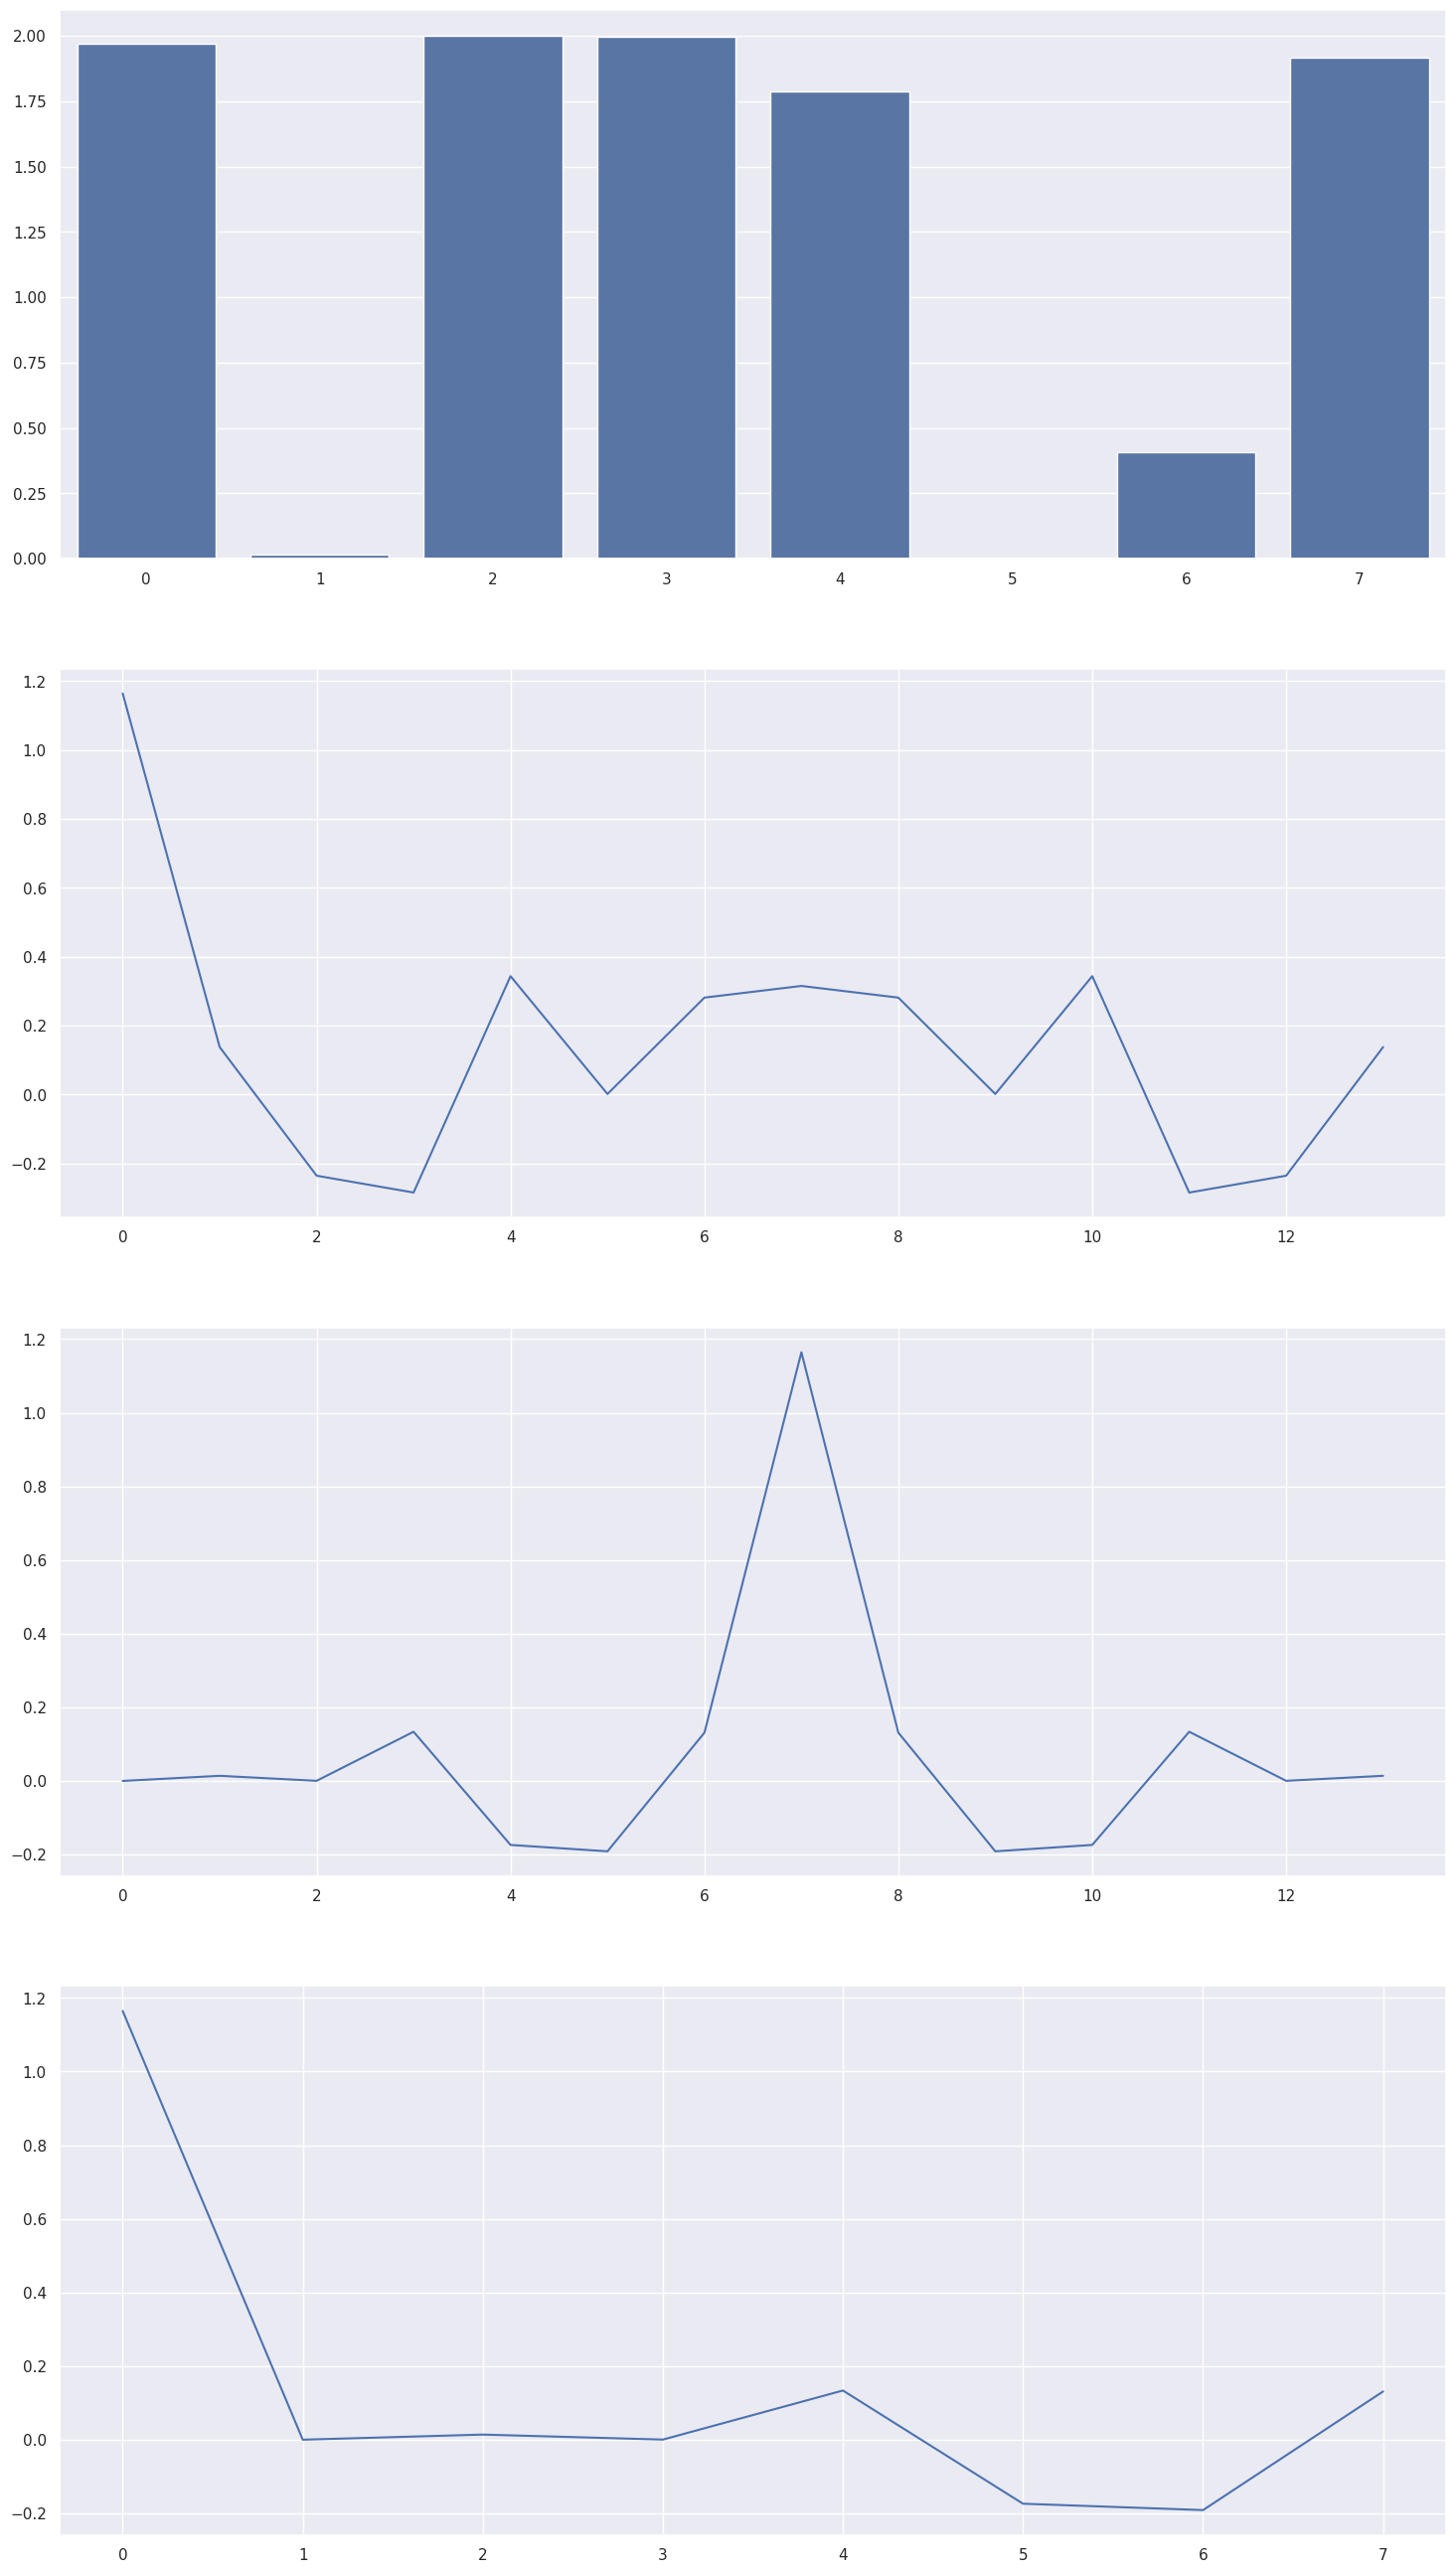

In [73]:
# fr = magnitudes[0, 0, ...]
# ir = irs[0, 0, ...]
fr = magnitudes
ir = irs

filter_size = ir.shape[-1]
print(filter_size)

rolled = torch.roll(ir, filter_size // 2, -1)
win = torch.hann_window(filter_size)

windowed = rolled * win

padded = torch.nn.functional.pad(windowed, (0, target_size - int(filter_size)))
final_ir = torch.roll(padded, -filter_size // 2, -1)
print(final_ir.shape)

fig, axs = plt.subplots(4, 1, figsize=(18, 33))
sns.barplot(pd.Series(fr[0][0]), ax=axs[0])
plot(axs[1], ir[0][0])
plot(axs[2], windowed[0][0])
plot(axs[3], final_ir[0][0])

# filtering some noise with the random magnitudes

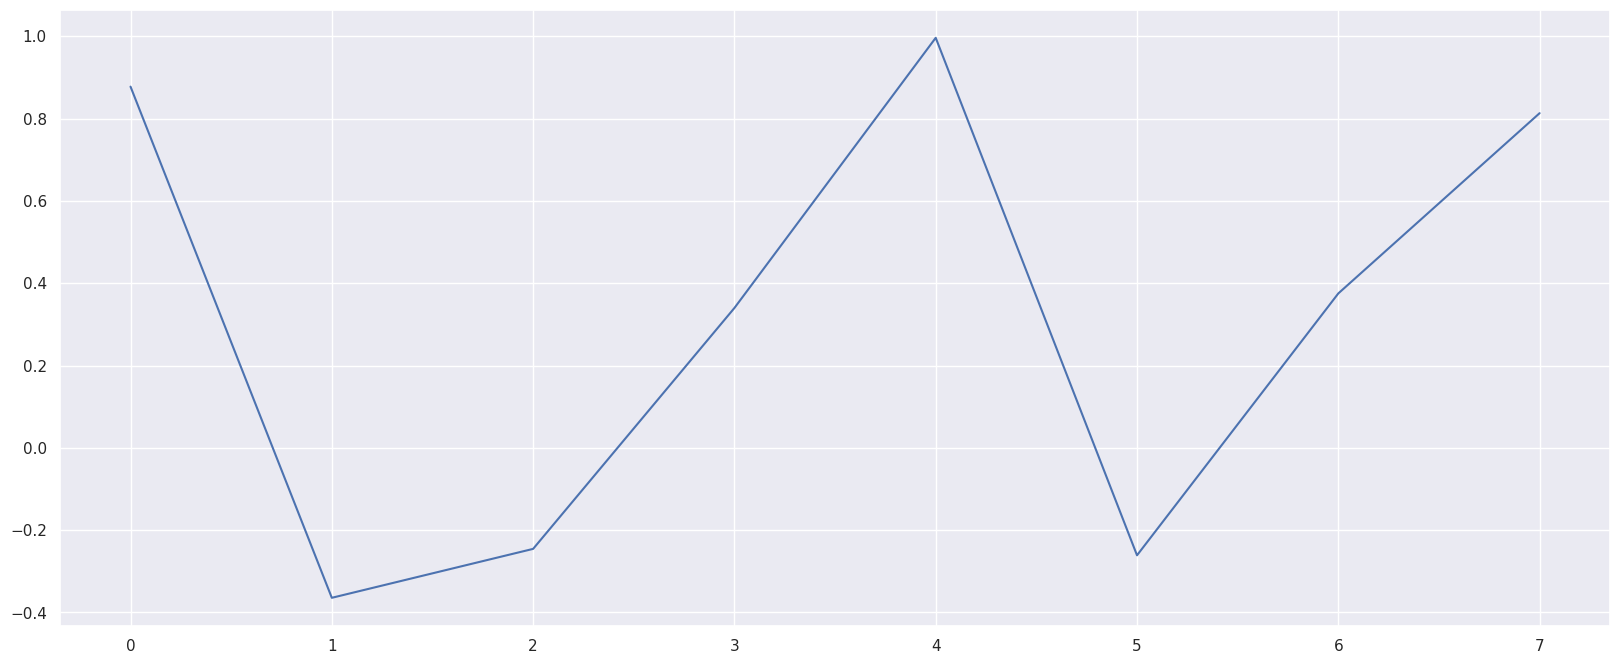

In [74]:
def fft_convolve(signal, kernel):
    """
    convolves signal by kernel on the last dimension
    """
    signal = torch.nn.functional.pad(signal, (0, signal.shape[-1]))
    kernel = torch.nn.functional.pad(kernel, (kernel.shape[-1], 0))

    output = torch.fft.irfft(torch.fft.rfft(signal) * torch.fft.rfft(kernel))
    output = output[..., output.shape[-1] // 2:]

    return output

noise = torch.rand_like(final_ir) * 2 - 1
fig, ax = plt.subplots(1, 1, figsize=(20, 8))
plot(ax, noise[0][0])

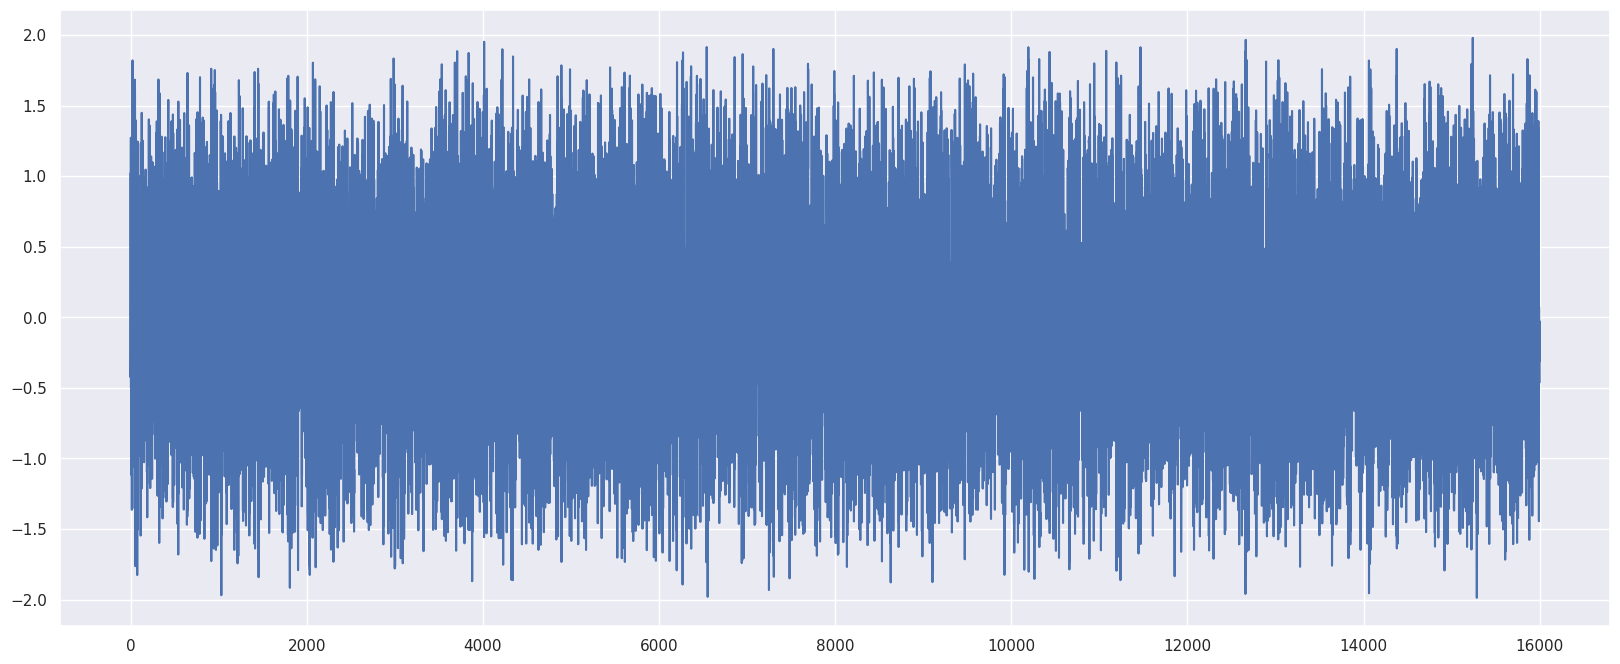

In [75]:
filtered_noise = (
    fft_convolve(noise, final_ir)
    .reshape(noise.shape[0], -1)  # (batch_size, n_frames, frame_length) -> (batch_size, length)
)

fig, ax = plt.subplots(1, 1, figsize=(20, 8))
plot(ax, filtered_noise[0])

In [76]:
IPython.display.Audio(filtered_noise[0], rate=48000)